<a href="https://colab.research.google.com/github/Mrinal18/Deep_Learning_Catalyst/blob/main/Deep_Learning_Catalyst_Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What is PyTorch?
It’s a Python based scientific computing package targeted at two sets of audiences:

Tensorial library that uses the power of GPUs
A deep learning research platform that provides maximum flexibility and speed

What is PyTorch?
It’s a Python based scientific computing package targeted at two sets of audiences:

Tensorial library that uses the power of GPUs
A deep learning research platform that provides maximum flexibility and speed

In [ ]:
import torch  # <Ctrl> / <Shift> + <Return>
Getting help in Jupyter
torch.sq  # <Tab>

# What about all `*Tensor`s?
# Press <esc> to get out of help
torch.*Tensor?
torch.nn.Module()  # <Shift>+<Tab>

# Annotate your functions / classes!
torch.nn.Module?

torch.nn.Module??


Python native data types
Python has many native datatypes. Here are the important ones:

**Booleans** are either True or False.

**Numbers** can be integers (1 and 2), floats (1.1 and 1.2), fractions (1/2 and 2/3), or even complex numbers.

**Strings** are sequences of Unicode characters, e.g. an html document.


**Lists** are ordered sequences of values.


**Tuples** are ordered, immutable sequences of values.


**Sets** are unordered bags of values.


**Dictionaries** are unordered bags of key-value pairs.


In [ ]:
# Generate a tensor of size 2x3x4
t = torch.Tensor(2, 3, 4)
type(t)

# Get the size of the tensor
t.size()

# t.size() is a classic tuple =>
print('t size:', ' \u00D7 '.join(map(str, t.size())))

# prints dimensional space and sub-dimensions
print(f'point in a {t.numel()} dimensional space')
print(f'organised in {t.dim()} sub-dimensions')


# Mind the underscore!
# Any operation that mutates a tensor in-place is post-fixed with an _.
# For example: x.copy_(y), x.t_(), x.random_(n) will change x.
t.random_(10)

# Creates a 1D tensor of integers 1 to 4
v = torch.Tensor([1, 2, 3, 4])
v
# Print number of dimensions (1D) and size of tensor
print(f'dim: {v.dim()}, size: {v.size()[0]}')
w = torch.Tensor([1, 0, 2, 0])
w
# Element-wise multiplication
v * w
# Scalar product: 1*1 + 2*0 + 3*2 + 4*0
v @ w
# In-place replacement of random number from 0 to 10
x = torch.Tensor(5).random_(10)
x
print(f'first: {x[0]}, last: {x[-1]}')
# Extract sub-Tensor [from:to)
x[1:2 + 1]
v
# Create a tensor with integers ranging from 1 to 5, excluding 5
v = torch.arange(1, 4 + 1)
v
# Square all elements in the tensor
print(v.pow(2), v)

### **Introduction To Catalyst** 

Catalyst is a PyTorch framework for Deep Learning Research and Development. It focuses on reproducibility, rapid experimentation, and codebase reuse so you can create something new rather than write yet another train loop.
Break the cycle – use the Catalyst!

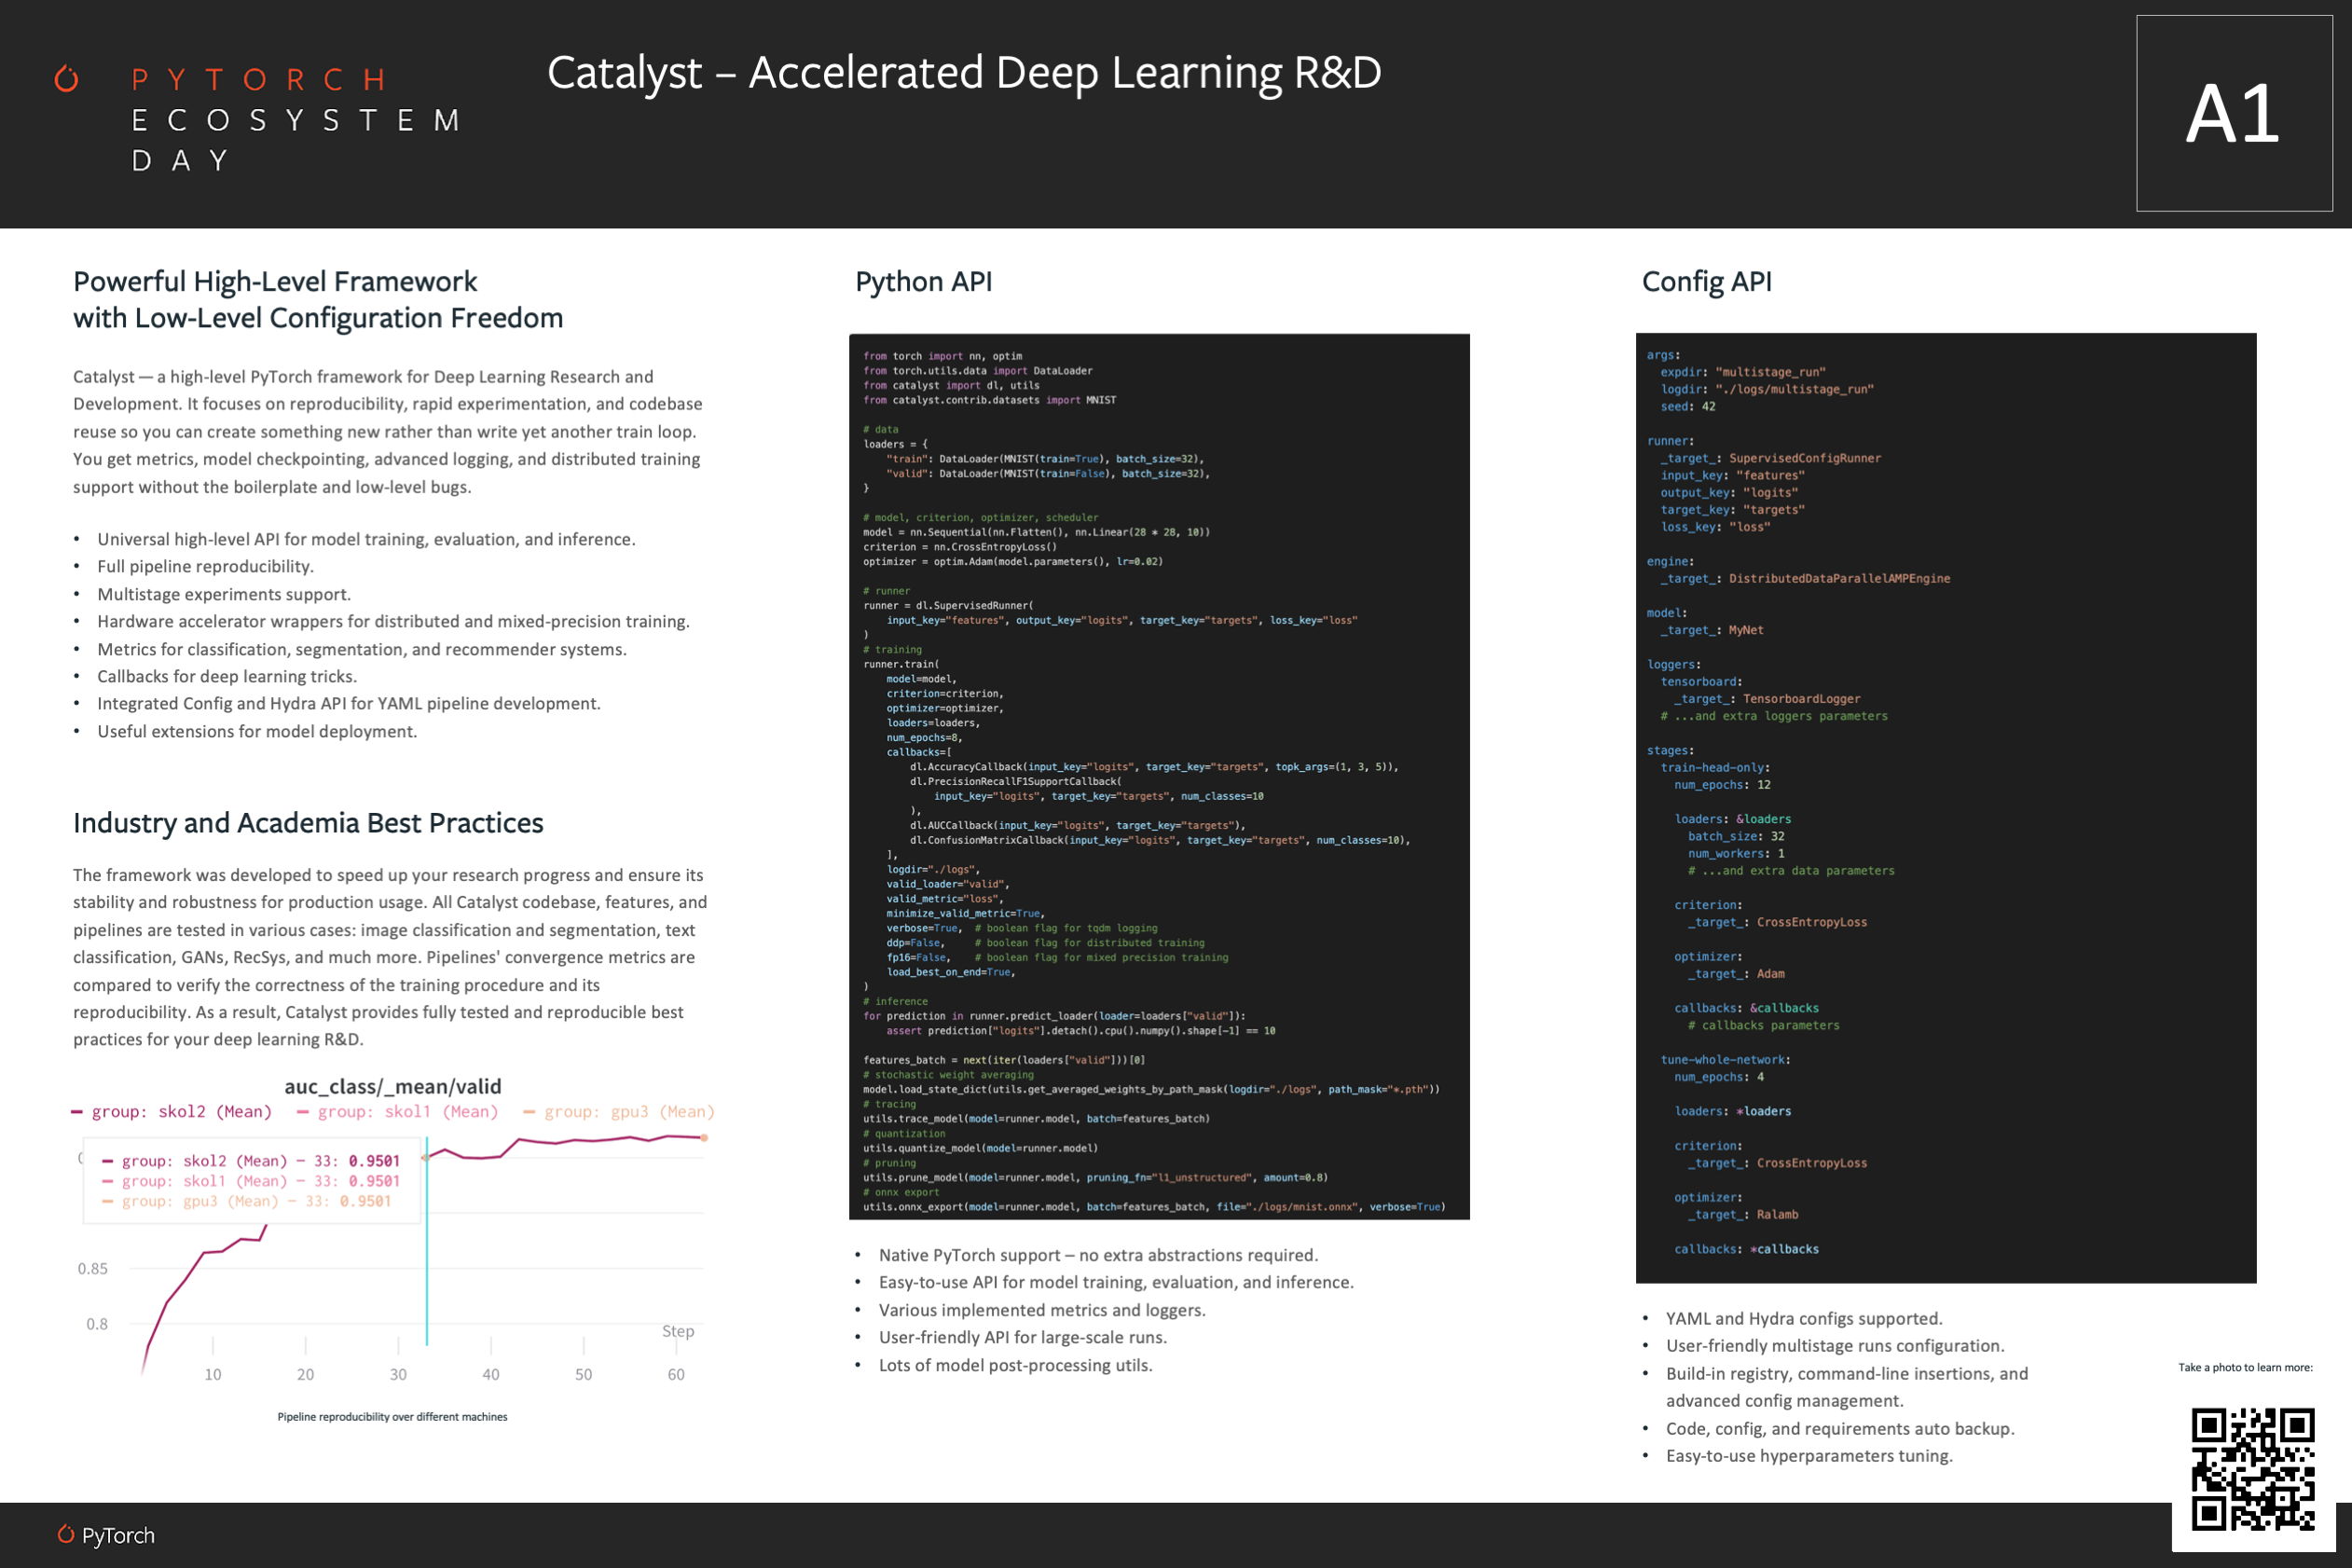

for referencem , please refer to https://github.com/catalyst-team/catalyst

### **Getting Started**

```
pip install -U catalyst
```

###How to start your journey with Catalyst

1. Start with Catalyst 101 — Accelerated PyTorch introduction.
Check minimal examples.
2. Try notebook tutorials with Google Colab.
3. Read blogposts with use-cases and guides (and Config API intro).
4. Go through advanced classification, detection and segmentation pipelines with Config API. More pipelines available under projects section.


source: https://opensourcelibs.com/lib/catalyst

### Examples using Catalyst

##Linear Regression Using Catalyst


Introduction to Linear Regression: 



In [ ]:
## import torch
from torch.utils.data import DataLoader, TensorDataset
from catalyst.dl import SupervisedRunner

# data
num_samples, num_features = int(1e4), int(1e1)
X, y = torch.rand(num_samples, num_features), torch.rand(num_samples)
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, num_workers=1)
loaders = {"train": loader, "valid": loader}

# model, criterion, optimizer, scheduler
model = torch.nn.Linear(num_features, 1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [3, 6])

# model training
runner = SupervisedRunner()
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    logdir="./logdir",
    num_epochs=8,
    verbose=True,
)

## MNIST classification

In [ ]:
import os
from torch import nn, optim
from torch.utils.data import DataLoader
from catalyst import dl, utils
from catalyst.data import ToTensor
from catalyst.contrib.datasets import MNIST

model = nn.Sequential(nn.Flatten(), nn.Linear(28 * 28, 10))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

train_data = MNIST(os.getcwd(), train=True, download=True, transform=ToTensor())
valid_data = MNIST(os.getcwd(), train=False, download=True, transform=ToTensor())
loaders = {
    "train": DataLoader(train_data, batch_size=32),
    "valid": DataLoader(valid_data, batch_size=32),
}

runner = dl.SupervisedRunner(
    input_key="features", output_key="logits", target_key="targets", loss_key="loss"
)

# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=1,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk_args=(1, 3, 5)),
        dl.PrecisionRecallF1SupportCallback(
            input_key="logits", target_key="targets", num_classes=10
        ),
    ],
    logdir="./logs",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
    load_best_on_end=True,
)

# model evaluation
metrics = runner.evaluate_loader(
    loader=loaders["valid"],
    callbacks=[dl.AccuracyCallback(input_key="logits", target_key="targets", topk_args=(1, 3, 5))],
)
assert "accuracy" in metrics.keys()

# model inference
for prediction in runner.predict_loader(loader=loaders["valid"]):
    assert prediction["logits"].detach().cpu().numpy().shape[-1] == 10

features_batch = next(iter(loaders["valid"]))[0]
# model stochastic weight averaging
model.load_state_dict(utils.get_averaged_weights_by_path_mask(logdir="./logs", path_mask="*.pth"))
# model tracing
utils.trace_model(model=runner.model, batch=features_batch)
# model quantization
utils.quantize_model(model=runner.model)
# model pruning
utils.prune_model(model=runner.model, pruning_fn="l1_unstructured", amount=0.8)
# onnx export
utils.onnx_export(model=runner.model, batch=features_batch, file="./logs/mnist.onnx", verbose=True)